**부동산 가격 추세를 가장 유사하게 추종하는 KOSPI 산업군 그룹은 무엇일까?**

이슈가 되고 있는 주식, 부동산 데이터를 바탕으로

코스피 산업군 군집분석 결과에 따른 주택매매가격지수와의 상관관계에 관한 분석 진행

사용 데이터

**데이콘 제공 데이터**  

- 주택매매가격지수(KB).csv  

**외부 데이터**  

- 전체 코스피 지수: [KRX 정보데이터시스템](http://data.krx.co.kr/contents/MDC/MAIN/main/index.cmd)  

- 산업별 코스피 지수: [KOSIS 국가통계포털](https://kosis.kr/statHtml/statHtml.do?orgId=343&tblId=DT_343_2010_S0190&vw_cd=&list_id=00000133&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=R1&path=)

코스피는 크게 22개의 산업군으로 나누어짐.

|  | | 
|:--------|:--------:|
|제조업| 음식료품 | 
|섬유의복| 종이목재 |
|화학| 의약품 |
|비금속광물| 철강금속 |
|기계| 전기전자 |
|의료정밀| 운수장비 |
|유통업| 전기가스업 |
|건설업| 운수창고업 |
|통신업| 금융업 |
|은행| 증권 |
|보험| 서비스업 |


군집분석을 통해 산업군의 군집을 파악하고 부동산 가격 추세를 가장 유사하게 추종하는 KOSPI 산업군 그룹을 파악하고자 함

In [1]:
# 필요 패키지 설치
!pip install tslearn
!pip install kneed

In [2]:
from sklearn.preprocessing import StandardScaler

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "notebook_connected"
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font', family='AppleGothic')

import seaborn as sns
plt.style.use('ggplot')

from kneed import KneeLocator

from datetime import date
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

In [3]:
kospi = pd.read_csv("./코스피_산업별_주가지수.csv", encoding = "CP949")
kospi.head()

,지수종류별(1),2000.01,2000.02,2000.03,2000.04,2000.05,2000.06,2000.07,2000.08,2000.09,...,2021.06,2021.07,2021.08,2021.09,2021.10,2021.11,2021.12,2022.01,2022.02,2022.03
0,제조업,1186.95,1051.13,1196.83,1017.99,979.88,1119.46,966.63,950.35,796.38,...,8261.35,8025.53,7973.65,7672.89,7370.66,7113.04,7591.60,6837.66,6801.86,6852.88
1,음식료품,1140.02,1064.90,1074.09,911.25,771.48,1024.68,887.04,877.24,825.45,...,4505.55,4429.20,4298.10,4093.83,4013.68,3551.91,3826.86,3630.62,3781.33,3848.52
2,섬유의복,355.40,350.45,375.93,313.76,250.99,259.71,248.88,275.08,271.78,...,436.01,433.36,473.83,460.64,514.99,471.26,518.08,464.32,493.89,458.70
3,종이목재,381.45,327.25,354.76,305.77,230.29,234.32,222.84,238.42,236.46,...,486.32,479.53,446.64,420.79,411.64,376.06,403.65,375.62,390.98,409.76
4,화학,797.70,716.03,755.94,624.65,527.90,580.40,531.98,547.35,508.83,...,7841.85,7436.03,7225.95,7328.99,7071.52,6066.63,6210.01,5745.19,5721.53,5714.70


In [4]:
kospi = kospi.set_index("지수종류별(1)").T

In [5]:
# 변수명 저장
column_name = kospi.columns
column_name

Index(['제조업', '음식료품', '섬유의복', '종이목재', '화학', '의약품', '비금속광물', '철강금속', '기계',
       '전기전자', '의료정밀', '운수장비', '유통업', '전기가스업', '건설업', '운수창고업', '통신업', '금융업',
       '은행', '증권', '보험', '서비스업'],
      dtype='object', name='지수종류별(1)')

## 산업군별 코스피 지수 시각화

In [6]:
fig = go.Figure()

for category in column_name:
    fig.add_trace(go.Scatter(y=kospi[category], mode = 'lines', name = category))


fig.show()

정확한 추세 비교를 위해 정규화를 진행 후 다시 시각화를 진행

## 정규화 진행 후 산업군별 코스피 시각화

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

fig = go.Figure()

for category in column_name:
    kospi[category] = scaler.fit_transform(pd.DataFrame(kospi[category]))
    fig.add_trace(go.Scatter(y=kospi[category], mode='lines', name=category))
    
fig.show()

## 군집분석(euclidean 사용)

In [8]:
# 군집분석을 위한 형태로 변형
kospi2 = to_time_series_dataset(kospi.values.T)

### 군집개수 설정을 위한 분석

In [33]:
value = []

for k in range(1, 10):
    model = TimeSeriesKMeans(n_clusters=k, metric='euclidean', verbose=False, random_state=42)
    model.fit(kospi2)
    value.append(model.inertia_)
    print(f'군집 수 {k}개 일때 Inertia value: {value[-1]}')

군집 수 1개 일때 Inertia value: 127.00668241002727
군집 수 2개 일때 Inertia value: 75.5413844643379
군집 수 3개 일때 Inertia value: 68.29317100432449
군집 수 4개 일때 Inertia value: 56.635808313225425
군집 수 5개 일때 Inertia value: 41.802419980211965
군집 수 6개 일때 Inertia value: 36.32898604971934
군집 수 7개 일때 Inertia value: 32.39499763458653
군집 수 8개 일때 Inertia value: 29.370392023064074
군집 수 9개 일때 Inertia value: 22.227193228428746


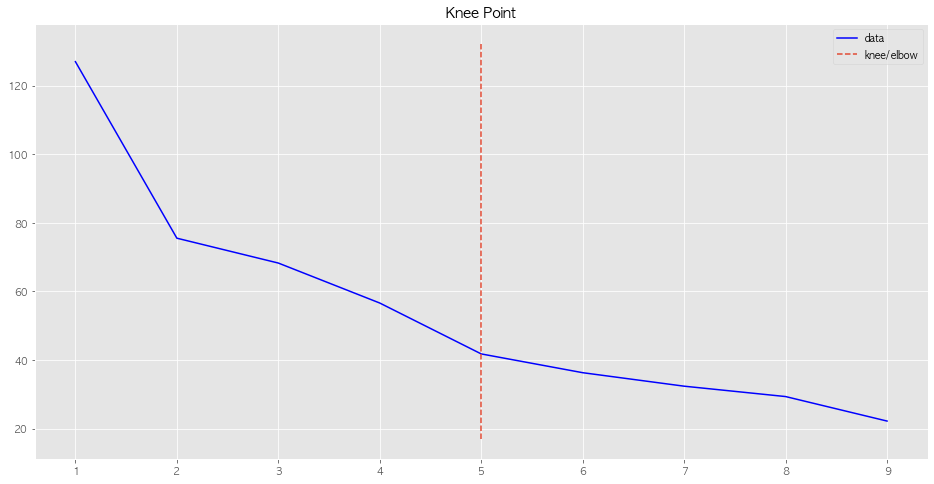

In [34]:
knee = KneeLocator(range(1, len(value)+1), value, curve='convex', direction='decreasing', online=True)
knee.plot_knee(figsize=(16,8))

- 다음은 적절한 군집개수를 파악하는데 도움을 주는 그래프
- 기준은 그래프가 완만해지는 순간을 기준으로 함.
- 위 그래프 별과 군집 개수가 3일때부터 완만해짐을 알 수 있음.
- 따라서 군집 개수 3개로 진행

### 군집분석 진행(k=2)

In [11]:
euclidean_k2 = TimeSeriesKMeans(n_clusters=2, metric='euclidean', verbose=True, random_state=42)
euclidean_k2_label = euclidean_k2.fit_predict(kospi2)

120.401 --> 75.541 --> 75.541 --> 


In [12]:
fig = go.Figure()

plot_names = []
buttons = []
states = []

cluster_value = np.unique(euclidean_k2_label)
default_cluster = "군집 1"

for i in range(len(cluster_value)):
    for cluster_i in np.argwhere(euclidean_k2_label == cluster_value[i]): # 각 클러스터에 해당하는 위치 찾기
        fig.add_trace(go.Scatter(x=kospi.iloc[:, cluster_i].index, y=kospi.iloc[:, cluster_i].values.flatten(), 
                                 name=kospi.columns[cluster_i][0], 
                                 line=dict(color="gray"), 
                                 visible=(f'군집 {i+1}'== default_cluster)))
    fig.add_trace(go.Scatter(x=kospi.iloc[:, cluster_i].index, 
                             y=euclidean_k2.cluster_centers_[cluster_value[i]].flatten(), 
                             name=f'군집 {i+1} 중심', 
                             line=dict(color="Orange"), 
                             visible=(f'군집 {i+1}'== default_cluster)))
    plot_names.extend([f'군집 {i+1}']*(len(np.argwhere(euclidean_k2_label == cluster_value[i]))+1))

for j in range(len(cluster_value)):
    states.append(f'군집 {j+1}')
    buttons.append(dict(method='update',
                        label=f'군집 {j+1}',
                        args = [{'visible': [f'군집 {j+1}'==r for r in plot_names]}]))

fig.update_layout(title_text='K-Means_Euclidean_k2', showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": states.index(default_cluster), "showactive": True, "x": 0.5, "y": 1.15}])

fig.show()

- 버튼 클릭하여 각 군집안에 포함된 산업군과 추세를 확인
    - 각 군집마다 추세의 특징이 존재함을 확인

### 군집 분석(k=3)

In [35]:
euclidean_k3 = TimeSeriesKMeans(n_clusters=5, metric='euclidean', verbose=True, random_state=42)
euclidean_k3_label = euclidean_k3.fit_predict(kospi2)

68.317 --> 41.802 --> 41.802 --> 


In [36]:
fig = go.Figure()

plot_names = []
buttons = []
states = []

cluster_value = np.unique(euclidean_k3_label)
default_cluster = "군집 1"

for i in range(len(cluster_value)):
    for cluster_i in np.argwhere(euclidean_k3_label == cluster_value[i]): # 각 클러스터에 해당하는 위치 찾기
        fig.add_trace(go.Scatter(x=kospi.iloc[:, cluster_i].index, y=kospi.iloc[:, cluster_i].values.flatten(), 
                                 name=kospi.columns[cluster_i][0], 
                                 line=dict(color="gray"), 
                                 visible=(f'군집 {i+1}'== default_cluster)))
    fig.add_trace(go.Scatter(x=kospi.iloc[:, cluster_i].index, 
                             y=euclidean_k3.cluster_centers_[cluster_value[i]].flatten(), 
                             name=f'군집 {i+1} 중심', 
                             line=dict(color="Orange"), 
                             visible=(f'군집 {i+1}'== default_cluster)))
    plot_names.extend([f'군집 {i+1}']*(len(np.argwhere(euclidean_k3_label == cluster_value[i]))+1))

for j in range(len(cluster_value)):
    states.append(f'군집 {j+1}')
    buttons.append(dict(method='update',
                        label=f'군집 {j+1}',
                        args = [{'visible': [f'군집 {j+1}'==r for r in plot_names]}]))

fig.update_layout(title_text='K-Means_Euclidean_k3', showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": states.index(default_cluster), "showactive": True, "x": 0.5, "y": 1.15}])

fig.show()

### PCA를 적용하여 군집이 잘 형성되었는지 확인

In [15]:
# 데이터 모양 변형
nsamle, nx, ny = kospi2.shape
kospi2_pca = kospi2.reshape((nsamle,nx*ny))

#### K = 2

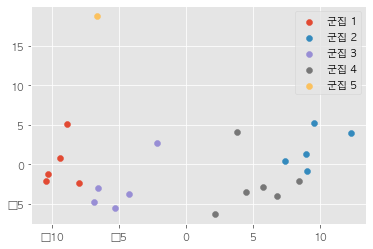

In [39]:
pca = PCA(n_components=2)  
pca_fit = pca.fit_transform(kospi2_pca)

for i in range(5):
  label_name = "군집 " +str(i+1)
  plt.scatter(pca_fit[[euclidean_k3_label==i]][:,0],pca_fit[[euclidean_k3_label==i]][:,1],label=label_name)

plt.legend()
plt.show()

#### K = 3

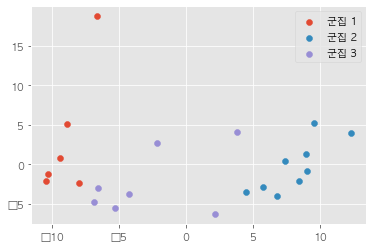

In [17]:
pca = PCA(n_components=2)  
pca_fit = pca.fit_transform(kospi2_pca)

for i in range(3):
  label_name = "군집 " +str(i+1)
  plt.scatter(pca_fit[[euclidean_k3_label==i]][:,0],pca_fit[[euclidean_k3_label==i]][:,1],label=label_name)

plt.legend()
plt.show()

- K=2, K=3일때를 비교해본 결과 K=2이 군집이 더 잘 형성됨을 보이므로 최종 군집 개수를 2개로 설정

군집분석 결과 각 군집별 중심값을 도출.
이 중심값과 주택매매지수와의 상관분석을 진행

## 상관분석 진행을 위한 데이터셋 통합

In [20]:
# 군집별 중심값 데이터셋
c1 = pd.DataFrame(euclidean_k2.cluster_centers_[0], columns=['군집1_중심'])
c2 = pd.DataFrame(euclidean_k2.cluster_centers_[1], columns=['군집2_중심'])
# c3 = pd.DataFrame(euclidean_k3.cluster_centers_[2], columns=['군집3_중심'])
# center_result = pd.concat([c1,c2,c3],axis=1)
center_result = pd.concat([c1,c2],axis=1)
center_result.index = kospi.index
center_result

,군집1_중심,군집2_중심
2000.01,0.068504,-0.871197
2000.02,-0.049638,-1.194429
2000.03,-0.075195,-1.262905
2000.04,-0.481680,-1.439667
2000.05,-0.543926,-1.495814
...,...,...
2021.11,1.799119,-0.064323
2021.12,1.969870,0.053009
2022.01,1.568072,-0.174037
2022.02,1.630391,-0.014293


In [21]:
# 군집별 중심값 데이터셋 저장
center_result.to_csv("./center_cluster_result.csv")

In [22]:
# 산업군별 코스피 데이터와 군집별 중심값 데이터 통합  
result_data = pd.concat([center_result,kospi],axis=1)
result_data.head()

,군집1_중심,군집2_중심,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
2000.01,0.068504,-0.871197,-1.225817,-1.280312,1.226106,0.905251,-1.315524,-0.975720,-1.083904,-1.423088,...,-0.864909,-0.047458,-0.517302,-1.189228,6.416662,-0.701944,-1.117533,0.538467,-1.678750,-0.304701
2000.02,-0.049638,-1.194429,-1.300054,-1.334983,1.174710,0.210014,-1.356935,-0.915619,-1.243593,-1.545237,...,-1.251067,-0.595973,-0.834659,-1.254362,5.654348,-1.356587,-1.768422,-0.045333,-1.776850,0.165258
2000.03,-0.075195,-1.262905,-1.220417,-1.328294,1.439269,0.562892,-1.336698,-0.928106,-1.200697,-1.561167,...,-1.047731,-0.276812,-0.868100,-1.180338,4.958111,-1.705544,-1.871929,-0.771095,-1.837387,-0.183763
2000.04,-0.481680,-1.439667,-1.318168,-1.446805,0.793759,-0.065515,-1.403269,-0.969087,-1.243254,-1.685445,...,-1.404958,-0.258602,-0.933528,-1.405338,2.700950,-1.986454,-1.913576,-1.354781,-1.921862,-0.562503
2000.05,-0.543926,-1.495814,-1.338998,-1.548526,0.142020,-1.033716,-1.452326,-0.993991,-1.334028,-1.696687,...,-1.688958,-0.482190,-1.032793,-1.547999,4.124455,-1.944579,-1.885767,-1.233279,-1.893224,-0.624518


In [23]:
# result_data 형식 변형
result_data2 = pd.melt(result_data,ignore_index=False)
result_data2

,variable,value
2000.01,군집1_중심,0.068504
2000.02,군집1_중심,-0.049638
2000.03,군집1_중심,-0.075195
2000.04,군집1_중심,-0.481680
2000.05,군집1_중심,-0.543926
...,...,...
2021.11,서비스업,2.541727
2021.12,서비스업,2.500180
2022.01,서비스업,1.604780
2022.02,서비스업,1.780615


In [24]:
# 데이터 컬럼명 변경
result_data2 = result_data2.rename(columns = {'variable':'산업구분', 'value':'값'})
result_data2.head()

,산업구분,값
2000.01,군집1_중심,0.068504
2000.02,군집1_중심,-0.049638
2000.03,군집1_중심,-0.075195
2000.04,군집1_중심,-0.481680
2000.05,군집1_중심,-0.543926


In [25]:
# 군집분석 결과를 바탕으로 나온 각 군집별 산업군 목록을 정의
cluster_1 = ['섬유의복','종이목재','통신업','군집1_중심']
cluster_2 = ['철강금속','기계','운수장비','유통업','전기가스업','건설업','운수창고업','금융업','은행','증권','보험', '군집2_중심']
cluster_3 = ['제조업','음식료품','화학','의약품','비금속광물','전기전자','의료정밀','서비스업', '군집3_중심']

In [26]:
# 군집구분 컬럼 추가를 위한 함수
def cluster(type):
    if type in cluster_1: return '군집1'
    elif type in cluster_2: return '군집2'
    else: return '군집3'

result_data2['군집구분'] = result_data2.apply(lambda x: cluster(x['산업구분']),axis=1)

In [27]:
# 군집1 확인
result_data2[result_data2['군집구분']=='군집1']['산업구분'].value_counts()

통신업       267
군집1_중심    267
종이목재      267
섬유의복      267
Name: 산업구분, dtype: int64

In [40]:
# 군집2 확인
result_data2[result_data2['군집구분']=='군집2']['산업구분'].value_counts()

운수창고업     267
유통업       267
건설업       267
기계        267
증권        267
전기가스업     267
금융업       267
군집2_중심    267
보험        267
은행        267
철강금속      267
운수장비      267
Name: 산업구분, dtype: int64

In [41]:
# 군집3 확인
result_data2[result_data2['군집구분']=='군집3']['산업구분'].value_counts()

음식료품     267
제조업      267
의약품      267
화학       267
서비스업     267
의료정밀     267
전기전자     267
비금속광물    267
Name: 산업구분, dtype: int64

## 상관분석


In [43]:
# 주택매매데이터 불러오기
trading = pd.read_csv("data/주택매매가격지수(KB).csv")
trading.head()

,Unnamed: 0,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100]
0,1986-01-01,34.656,61.347,43.053,20.973,17.153,30.044
1,1986-02-01,34.656,61.347,42.925,20.973,17.183,30.044
2,1986-03-01,34.708,61.513,42.733,20.935,17.153,30.002
3,1986-04-01,34.449,61.097,42.733,20.819,17.034,29.837
4,1986-05-01,34.293,60.848,41.837,20.664,16.945,29.588


In [44]:
# 날짜를 인덱스로 변경
trading = trading.rename(columns={"Unnamed: 0":"날짜"})
trading = trading.set_index('날짜')
trading = pd.DataFrame(trading)
trading.head()

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100]
날짜,,,,,,
1986-01-01,34.656,61.347,43.053,20.973,17.153,30.044
1986-02-01,34.656,61.347,42.925,20.973,17.183,30.044
1986-03-01,34.708,61.513,42.733,20.935,17.153,30.002
1986-04-01,34.449,61.097,42.733,20.819,17.034,29.837
1986-05-01,34.293,60.848,41.837,20.664,16.945,29.588


In [45]:
# 날짜 2000년부터 
trading = trading.loc["2000-01-01": "2021-03-01"]
trading

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100]
날짜,,,,,,
2000-01-01,48.819,72.153,56.103,39.474,31.660,39.451
2000-02-01,49.027,72.236,56.231,39.783,32.136,39.782
2000-03-01,49.234,72.319,56.615,40.015,32.433,40.114
2000-04-01,49.286,72.236,56.679,40.092,32.433,40.238
2000-05-01,49.234,72.153,56.615,40.015,32.403,40.238
...,...,...,...,...,...,...
2020-11-01,107.125,104.334,106.398,107.506,114.853,112.139
2020-12-01,108.586,104.909,107.237,109.346,116.365,113.532
2021-01-01,109.878,105.303,107.895,111.005,118.230,114.974


In [46]:
result_data

,군집1_중심,군집2_중심,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
2000.01,0.068504,-0.871197,-1.225817,-1.280312,1.226106,0.905251,-1.315524,-0.975720,-1.083904,-1.423088,...,-0.864909,-0.047458,-0.517302,-1.189228,6.416662,-0.701944,-1.117533,0.538467,-1.678750,-0.304701
2000.02,-0.049638,-1.194429,-1.300054,-1.334983,1.174710,0.210014,-1.356935,-0.915619,-1.243593,-1.545237,...,-1.251067,-0.595973,-0.834659,-1.254362,5.654348,-1.356587,-1.768422,-0.045333,-1.776850,0.165258
2000.03,-0.075195,-1.262905,-1.220417,-1.328294,1.439269,0.562892,-1.336698,-0.928106,-1.200697,-1.561167,...,-1.047731,-0.276812,-0.868100,-1.180338,4.958111,-1.705544,-1.871929,-0.771095,-1.837387,-0.183763
2000.04,-0.481680,-1.439667,-1.318168,-1.446805,0.793759,-0.065515,-1.403269,-0.969087,-1.243254,-1.685445,...,-1.404958,-0.258602,-0.933528,-1.405338,2.700950,-1.986454,-1.913576,-1.354781,-1.921862,-0.562503
2000.05,-0.543926,-1.495814,-1.338998,-1.548526,0.142020,-1.033716,-1.452326,-0.993991,-1.334028,-1.696687,...,-1.688958,-0.482190,-1.032793,-1.547999,4.124455,-1.944579,-1.885767,-1.233279,-1.893224,-0.624518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021.11,1.799119,-0.064323,2.013295,0.474997,2.429078,0.836112,1.356089,2.326823,2.837251,0.123783,...,-0.372915,-0.882839,-0.421077,0.139207,0.743424,0.195312,-0.447516,0.143407,-0.096122,2.541727
2021.12,1.969870,0.053009,2.274868,0.675099,2.915209,1.190016,1.428789,2.279504,2.825393,0.262399,...,-0.116865,-0.686657,-0.334369,0.392850,0.923787,0.191735,-0.674065,0.242796,-0.019978,2.500180
2022.01,1.568072,-0.174037,1.862776,0.532281,2.357020,0.830468,1.193102,1.608130,2.196851,0.175358,...,-0.425628,-0.869191,-0.463638,0.123717,0.819337,-0.075304,-1.295110,0.068227,0.050510,1.604780
2022.02,1.630391,-0.014293,1.843208,0.641963,2.664045,1.027495,1.181106,1.762190,2.294036,0.351294,...,-0.293558,-0.491131,-0.366092,0.471454,0.796065,0.062621,-1.031118,0.151747,0.019489,1.780615


In [47]:
# cluster 결과 데이터와 주택매매가격지수 데이터 통합
cluster_trading = pd.concat([trading, result_data], axis=1)
cluster_trading.head()

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100],군집1_중심,군집2_중심,제조업,식료품,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
2000-01-01,48.819,72.153,56.103,39.474,31.660,39.451,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,49.027,72.236,56.231,39.783,32.136,39.782,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,49.234,72.319,56.615,40.015,32.433,40.114,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,49.286,72.236,56.679,40.092,32.433,40.238,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,49.234,72.153,56.615,40.015,32.403,40.238,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
